<a href="https://colab.research.google.com/github/dtuleva/Recipe_Recommendation_System/blob/main/RRS_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
!pip install -q tensorflow-recommenders

In [67]:
!pip install -q mlflow

In [68]:
!pip install -U -q tensorboard_plugin_profile

In [69]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [260]:
from typing import Dict, Text

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_recommenders as tfrs

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, IntegerLookup, Embedding, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from transformers import DistilBertTokenizer, TFDistilBertModel

import mlflow

# Recipe Recommendation System
## part 3 - Experiments

## Data pipeline

In [71]:
# ratings_data = pd.read_csv("/content/gdrive/MyDrive/RRS_data/core-data-train_rating.csv")
# ratings_data_val = pd.read_csv("/content/gdrive/MyDrive/RRS_data/core-data-valid_rating.csv")
# recipes_data = pd.read_csv("/content/gdrive/MyDrive/RRS_data/core-data_recipe.csv")

In [72]:
ratings_data = pd.read_csv("/content/mock-data_interaction_10.csv")

In [73]:
ratings_data

,index,user_id,recipe_id,rating,dateLastModified
0,0,8542392,222388,5,1492865203663000000
1,1,11174581,222388,5,1371743425960000000
2,4,12145410,240488,2,1515197169563000000
3,8,2805827,240488,4,1509670081040000000
4,49,2963807,87211,3,1213273004050000000
5,50,674114,87211,5,1206758307153000000
6,51,2056462,87211,5,1227642798057000000
7,207,2945555,245714,5,1452873251537000000
8,208,10819660,245714,4,1470519746130000000
9,491,9101203,23658,1,1333706997547000000


In [74]:
# # TODO: move to pipeline
# ratings_data.dateLastModified = pd.to_datetime(ratings_data.dateLastModified).astype(int)

In [75]:
# recipes_unique = ratings_data.recipe_id.unique()

In [76]:
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_data))
# # ratings_val = tf.data.Dataset.from_tensor_slices(dict(ratings_data_val))
# recipes = tf.data.Dataset.from_tensor_slices(recipes_unique)

### Create tensorflow datasets

To achieve faster performance in reading, preprocessing and loading our dataset in the GPU we take advantage of tf.data.AUTOTUNE. It will infer the optimal number of parallel reads and prefetch buffer size for us.

In [77]:
AUTOTUNE = tf.data.AUTOTUNE

We read our interactions dataset:

In [78]:
# ratings = tf.data.experimental.make_csv_dataset(
#     file_pattern = "./mock-data_interaction_10.csv",
#     batch_size = 1,
#     # column_names=None,
#     # column_defaults=None,
#     # label_name=None,
#     # select_columns=None,
#     # field_delim=',',
#     # use_quote_delim=True,
#     # na_value='',
#     # header=True,
#     num_epochs = 1,
#     # num_epochs=None, # remember to put num epochs in fit!
#     shuffle = True,
#     shuffle_buffer_size = 10000,
#     shuffle_seed = 420042,
#     prefetch_buffer_size = AUTOTUNE,
#     num_parallel_reads = AUTOTUNE,
#     # sloppy=False,
#     # num_rows_for_inference=100,
#     # compression_type=None,
#     # ignore_errors=False,
#     # encoding='utf-8'
# )

In [79]:
for el in ratings.take(1):
  print(el)

{'index': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'user_id': <tf.Tensor: shape=(), dtype=int64, numpy=8542392>, 'recipe_id': <tf.Tensor: shape=(), dtype=int64, numpy=222388>, 'rating': <tf.Tensor: shape=(), dtype=int64, numpy=5>, 'dateLastModified': <tf.Tensor: shape=(), dtype=int64, numpy=1492865203663000000>}


In [80]:
ratings_cardinality = ratings.cardinality()
ratings_cardinality

<tf.Tensor: shape=(), dtype=int64, numpy=10>

It appears that we cannot infer the cardinality of the dataset correctly, so we hardcode it and move on.

In [81]:
ratings_cardinality = 10
ratings_cardinality

10

We iterate through the whole dataset to get the unique user and recipe ids - we will need them for our user and recipe embeddings.

In [82]:
unique_recipe_ids = np.unique(np.concatenate(list(ratings.batch(ratings_cardinality).map(lambda x: x["recipe_id"]))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(ratings_cardinality).map(lambda x: x["user_id"]))))

print(f"Uniqie recipes: {len(unique_recipe_ids)}\nUnique users: {len(unique_user_ids)}")

Uniqie recipes: 5
Unique users: 10


In [83]:
timestamps = np.concatenate(list(ratings.map(lambda x: x["dateLastModified"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

print(f"Min timestamp: {pd.to_datetime(min_timestamp)}\nMax timestamp: {pd.to_datetime(max_timestamp)}")

Min timestamp: 2008-03-29 02:38:27.153000
Max timestamp: 2018-01-06 00:06:09.563000


We create a recipe dataset from the unique recipe ids. That will be our candidate pool - the set of recipes from wich we retrieve our recommendations.

In [84]:
recipes = tf.data.Dataset.from_tensor_slices(unique_recipe_ids)

### Preprocessing functions

Here we have all the preprocessing functions that we map to our datasets. Our pipeline consists the following:
  1. Explicitly name our features to create a dict-like tf dataset in order to remove unused features and ensure there is no name mismatch.
  2. For each observation (line in the dataset) read and parse a proto file that contains the recipe information - name and image. All text features are already tockenized with DistilBERT tokenizer; the images are jpeg encoded. More information on the methods used to create the protofiles in the notebook "Dataset_Manipulation.ipynb".
  3. Decode recipe image, resize it to fixed dimentions and preprocess it with Resnet50's input preprocessor.

In [85]:
# def load_image(recipe_id, dir_path = "/content/"):

#   image_path = dir_path + tf.strings.as_string(recipe_id) + ".jpg"
#   img = tf.io.read_file(image_path)
#   img = tf.io.decode_jpeg(img)

#   return img

In [86]:
def decode_and_preprocess_image(img, image_size = (224, 224)):

    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img, image_size)
    img = preprocess_input(img) # tensorflow.keras.applications.resnet50.preprocess_input
    # The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

    return img


In [87]:
def parse_proto_example(proto):
    SEQUENCE_LEN = 32
    feature_description = {
      "recipe_id": tf.io.FixedLenFeature([], tf.int64),
      "recipe_name": tf.io.FixedLenFeature([], tf.string),
      "recipe_name_input_ids": tf.io.FixedLenFeature([SEQUENCE_LEN], tf.int64),
      "recipe_name_attention_mask": tf.io.FixedLenFeature([SEQUENCE_LEN], tf.int64),
      "recipe_image": tf.io.FixedLenFeature([], tf.string),
      "aver_rate": tf.io.FixedLenFeature([], tf.float32),
      "review_nums": tf.io.FixedLenFeature([], tf.int64),
      "ingredients": tf.io.FixedLenFeature([], tf.string),
      "cooking_directions": tf.io.FixedLenFeature([], tf.string),
      "reviews": tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(proto, feature_description)

In [88]:
def read_and_parse_proto_file(recipe_id, dir_path = "./"):

    file_path = dir_path + tf.strings.as_string(recipe_id) + ".proto"
    proto = tf.io.read_file(file_path)

    return parse_proto_example(proto)


In [89]:
def preprocess_recipe_info(element):
      # recipe["recipe_id"]
      # "recipe_name"
      element["recipe_image"] = decode_and_preprocess_image(element["recipe_image"])
      # "aver_rate"
      # "review_nums"
      # "ingredients"
      # "cooking_directions"
      # "reviews"

      return element


In [90]:
def plot_original_image(recipe_id, ax = None):
  # helper function used only for visualisation of the image before preprocessing
  img = read_and_parse_proto_file(recipe_id)["recipe_image"]
  img = tf.io.decode_jpeg(img)
  ax.imshow(img)

  return ax

We map the datasets to our pipeline functions:

In [91]:
# def read_and_parse_proto_file(recipe_id, dir_path = "./"):

#     file_path = dir_path + tf.strings.as_string(recipe_id) + ".proto"
#     file_path = tf.strings.join([dir_path,tf.strings.as_string(recipe_id), ".proto"])
#     print(file_path)
#     proto = tf.io.read_file("/content/240488.proto")
#     return proto
#     return parse_proto_example(proto)

In [92]:
def id_to_filepath(recipe_id, dir_path = "./"):
  return dir_path + tf.strings.as_string(recipe_id) + ".proto"

In [93]:
# tf.py_func(id_to_filepath, [s], (tf.string, tf.int64))

In [94]:
# for el in ratings.take(1):
#   print(el)

In [95]:
ratings = ratings.map(lambda x: {
    "recipe_id": x["recipe_id"],
    "user_id": x["user_id"],
    "dateLastModified": x["dateLastModified"],
    **read_and_parse_proto_file(x["recipe_id"]),
    }).map(preprocess_recipe_info)


In [96]:
recipes = recipes.map(lambda x: {
    **read_and_parse_proto_file(x)
    }).map(preprocess_recipe_info)

In [97]:
# for el in ratings.take(1):
#   [print(f"{k}: {v}") for k, v in el.items()]




In [98]:
# for el in recipes.take(1):
#   print(el)

Let's visualise an example of our dataset in human-readable form and check weather the parsing and preprocess work correctly. The original image is not fed to the model - we use it only for comparison with the preprocessed. Note that matplotlib is not visualising the preprocessed image properly because of the reodered channels and different range (pixel values are neither 0 to 255, nor 0 to 1).  

recipe_id: 222388
user_id: 8542392
dateLastModified: 1492865203663000000
aver_rate: 5.0
cooking_directions: b'pork belly^smoked paprika^kosher salt^ground black pepper'
ingredients: b'pork belly^smoked paprika^kosher salt^ground black pepper'
recipe_name: b'Homemade Bacon'
recipe_name_attention_mask: [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
recipe_name_input_ids: [  101 25628 11611   102     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
review_nums: 3
reviews: b'{8542392: {\'rating\': 5, \'followersCount\': 11, \'madeRecipesCount\': 18, \'favoritesCount\': 200, \'dateLastModified\': u\'2017-04-22T12:46:43.663\', \'text\': u"Best breakfast ever! I ran out of paprika while seasoning, so I used garlic piercer on the other half of the batch. Very good! Can\'t wait to make it again... and figure out how to use the drippings!", \'followingCount\': 

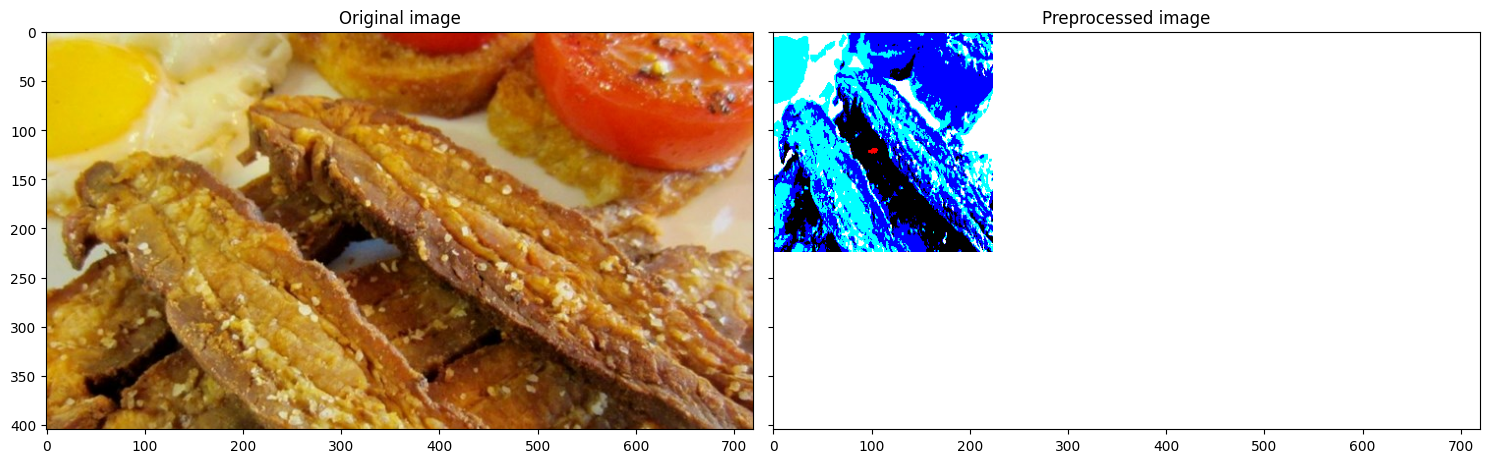

In [99]:
for el in ratings.take(1):
  [print(f"{k}: {v}") for k, v in el.items() if k != "recipe_image"]
  recipe_id = el["recipe_id"]
  image = el["recipe_image"]
  recipe_name = el["recipe_name"]

  # fig, axs = plt.subplots(1,2, figsize=(14, 8))

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), sharex = True, sharey = True)
  # plt.suptitle(f'User id: {el["user_id"]}\nRating: {5}\nDatestamp: {el["dateLastModified"]}\nRecipe id: {recipe_id}\nRecipe name: {el["recipe_name"]}')

  ax[1].imshow(image)
  plot_original_image(recipe_id, ax = ax[0])


  ax[0].set_title("Original image")
  ax[1].set_title("Preprocessed image")

  # ax[0].text(800, 20, f"Recipe name tockrnized {el['recipe_name_input_ids'].numpy()}")

  plt.tight_layout()
  plt.show()


In [100]:
ratings.cardinality(), recipes.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=10>,
 <tf.Tensor: shape=(), dtype=int64, numpy=5>)

In [101]:
# AUTOTUNE = tf.data.AUTOTUNE

# # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
# dog_muffin_list_train_perf_config = dog_muffin_list_train.map(process_path, num_parallel_calls=AUTOTUNE)
# dog_muffin_list_val_perf_config = dog_muffin_list_val.map(process_path, num_parallel_calls=AUTOTUNE)

In [102]:
# def configure_for_performance(ds):
#   ds = ds.cache()
#   ds = ds.shuffle(buffer_size=ds.cardinality())
#   ds = ds.batch(batch_size)
#   ds = ds.prefetch(buffer_size=AUTOTUNE)
#   return ds

# dog_muffin_list_train_perf_config = configure_for_performance(dog_muffin_list_train_perf_config)
# dog_muffin_list_val_perf_config = configure_for_performance(dog_muffin_list_val_perf_config)

In [242]:
ratings_train = ratings.take(8).batch(2)
ratings_val = ratings.skip(8).take(2).batch(2)

## Model

In [104]:
embedding_dimension = 32

### Backbone exploration

#### Resnet50

#### DistillBert

### Query model

In [186]:
# # query tower

# user_model = Sequential([
#   IntegerLookup(
#       vocabulary=unique_user_ids, mask_token=None),
#   # We add an additional embedding to account for unknown tokens.
#   tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
# ])

In [187]:
timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

In [188]:
class UserModel(tf.keras.Model):

  def __init__(self, use_timestamps):
    super().__init__()

    self._use_timestamps = use_timestamps

    self.user_embedding = tf.keras.Sequential([
        Input(shape=(1,)),
        tf.keras.layers.IntegerLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])

    if use_timestamps:
      self.timestamp_embedding = tf.keras.Sequential([
          tf.keras.layers.Discretization(timestamp_buckets.tolist()),
          tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
      ])
      self.normalized_timestamp = tf.keras.layers.Normalization(
          axis=None
      )

      self.normalized_timestamp.adapt(timestamps)

  def call(self, inputs):
    if not self._use_timestamps:
      return self.user_embedding(inputs["user_id"])

    return tf.concat([
        self.user_embedding(inputs["user_id"]),
        self.timestamp_embedding(inputs["dateLastModified"]),
        tf.reshape(self.normalized_timestamp(inputs["dateLastModified"]), (-1, 1)),
    ], axis=1)

### Candidate model

#### Recipe ID

In [189]:
# id hash / integer lookup

#### Recipe Image

In [190]:
resnet50 = ResNet50()

In [191]:
# resnet50.summary()

In [192]:
sample_images = recipes.take(5).map(lambda x: x["recipe_image"])
sample_images

<_MapDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>

In [193]:
decode_predictions(resnet50.predict(sample_images.batch(10)), top = 3)

1/1 [==============================] - 3s 3s/step


[[('n07693725', 'bagel', 0.42316934),
  ('n07697313', 'cheeseburger', 0.2725189),
  ('n07697537', 'hotdog', 0.082541764)],
 [('n07684084', 'French_loaf', 0.7221588),
  ('n02776631', 'bakery', 0.041738123),
  ('n07717410', 'acorn_squash', 0.03962634)],
 [('n02776631', 'bakery', 0.39453843),
  ('n07871810', 'meat_loaf', 0.16423157),
  ('n07697537', 'hotdog', 0.09502021)],
 [('n07711569', 'mashed_potato', 0.55543333),
  ('n07871810', 'meat_loaf', 0.12479975),
  ('n07684084', 'French_loaf', 0.08913466)],
 [('n07831146', 'carbonara', 0.30425817),
  ('n07860988', 'dough', 0.13138953),
  ('n04597913', 'wooden_spoon', 0.12432582)]]

In [194]:
sample_images = recipes.take(5).map(lambda x: x["recipe_image"])

In [195]:
decode_predictions(resnet50.predict(sample_images.batch(10)), top = 3)

1/1 [==============================] - 1s 961ms/step


[[('n07693725', 'bagel', 0.42316934),
  ('n07697313', 'cheeseburger', 0.2725189),
  ('n07697537', 'hotdog', 0.082541764)],
 [('n07684084', 'French_loaf', 0.7221588),
  ('n02776631', 'bakery', 0.041738123),
  ('n07717410', 'acorn_squash', 0.03962634)],
 [('n02776631', 'bakery', 0.39453843),
  ('n07871810', 'meat_loaf', 0.16423157),
  ('n07697537', 'hotdog', 0.09502021)],
 [('n07711569', 'mashed_potato', 0.55543333),
  ('n07871810', 'meat_loaf', 0.12479975),
  ('n07684084', 'French_loaf', 0.08913466)],
 [('n07831146', 'carbonara', 0.30425817),
  ('n07860988', 'dough', 0.13138953),
  ('n04597913', 'wooden_spoon', 0.12432582)]]

In [196]:
resnet50_backbone = ResNet50(include_top = False, input_shape = (224, 224, 3))

In [197]:
resnet50_backbone.input_shape

(None, 224, 224, 3)

In [198]:
resnet50_backbone.layers[-1].output_shape

(None, 7, 7, 2048)

In [199]:
resnet50_backbone.trainable = False

In [200]:
image_embedding = tf.keras.Sequential(
    layers = [
      Input(shape=(224, 224, 3)),
      resnet50_backbone,
      GlobalAveragePooling2D(),
      Dense(32)
      ],
    name = "image_embedding"
)

In [201]:
image_embedding.summary()

Model: "image_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 32)                65568     
                                                                 
Total params: 23653280 (90.23 MB)
Trainable params: 65568 (256.12 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [202]:
for el in recipes.batch(1).take(2):
  print(el['recipe_image'].shape)
  print(image_embedding(el['recipe_image']))

(1, 224, 224, 3)
tf.Tensor(
[[ 1.002742    1.247056   -1.5234168  -0.80613     0.33762348 -2.1622534
  -0.8020565  -1.6415421   0.8449093   1.1484312  -2.04535    -0.5436544
  -0.527902   -0.09207685  0.15057659 -1.0027002  -0.08001044 -0.30367273
   0.5771288  -2.2792192  -1.4099979  -0.71429396  0.85359     1.694244
   1.5482031  -1.5796076  -1.4141492   2.9886796   0.6583301   0.00916561
   0.03174033 -3.7743912 ]], shape=(1, 32), dtype=float32)
(1, 224, 224, 3)
tf.Tensor(
[[ 2.2965097   0.61634755 -1.0923694  -1.2248449  -0.01792241 -0.9756706
  -1.7631458   0.1558397   1.3144667  -0.5995277  -1.8669652  -1.50969
   0.51670605 -0.5973547  -0.44952503 -0.7433831   0.8730302   0.7040543
   0.31796047 -2.6777828   0.6555437  -0.72870624  0.78000593  0.15229152
   2.25029    -0.29732686 -0.5625901   0.5894697   0.2483212   1.1681919
   0.41708902 -1.3689592 ]], shape=(1, 32), dtype=float32)


### Recipe name

In [203]:
# keras_nlp.models.DistilBertMaskedLM(backbone, preprocessor=None, **kwargs)

In [204]:
# from keras_nlp.models import DistilBertTokenizer

In [205]:
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [206]:
dbert_model.summary()

Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
Total params: 66362880 (253.15 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [207]:
dbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [208]:
recipe_names = recipes.map(lambda x: x["recipe_name"])

In [209]:
sample_names_input = []
for el in recipe_names.take(2):
  print(el)
  string_value = tf.compat.as_str_any(el.numpy())
  print(string_value)
  tokenized_input = dbert_tokenizer(string_value, add_special_tokens = True, max_length = 124, padding = "max_length", truncation = True)
  print(tokenized_input)
  sample_names_input.append(tokenized_input)
  print(dbert_tokenizer.decode(tokenized_input["input_ids"]))

tf.Tensor(b"Pam's Bierocks", shape=(), dtype=string)
Pam's Bierocks
{'input_ids': [101, 14089, 1005, 1055, 12170, 10624, 10603, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
[CLS] pam's bierocks [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [210]:
def tokenize_and_encode(sentence):
    tokens = dbert_tokenizer.encode_plus(sentence.numpy().decode('utf-8'), padding='max_length', truncation=True, max_length=64, return_tensors='tf')
    return {
        'input_ids': tokens['input_ids'][0],
        'attention_mask': tokens['attention_mask'][0],
    }

In [211]:
tokenized_names = recipes.map(lambda x: (x["recipe_name_input_ids"], x["recipe_name_attention_mask"]))

In [212]:
for recipe in tokenized_names.take(2):
  print(dbert_tokenizer.decode(recipe[0]))

[CLS] pam's bierocks [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] chicken pesto paninis [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [213]:
# for el in ingredients.take(2):
#   print(el)
#   string_value = tf.compat.as_str_any(el.numpy())
#   print(string_value)
#   tokenized_input = dbert_tokenizer(string_value)
#   print(tokenized_input)
#   print(dbert_tokenizer.decode(tokenized_input["input_ids"]))

In [214]:
dbert_layer.name

'tf.__operators__.getitem_2/strided_slice:0'

In [267]:
max_len = 32
inps = Input(shape = (max_len,), dtype='int64')
masks= Input(shape = (max_len,), dtype='int64')
dbert_layer = dbert_model(inps, attention_mask=masks)[0][:,0,:]
dense = Dense(254)(dbert_layer)
dense = Dense(32)(dense)
recipe_name_embedding = tf.keras.Model(inputs=[inps,masks], outputs=dense, name = "recipe_name_embedding")

recipe_name_embedding.summary()

Model: "recipe_name_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_2[0][0]',             
 stilBertModel)              den_state=(None, 32, 768),   0          'input_3[0][0]']             
                              hidden_states=None, atten                                           
                             tions=None)                                      

In [216]:
dbert_layer.name

'tf.__operators__.getitem/strided_slice:0'

In [217]:
# input_ids=[]
# attention_masks=[]

# for sent in ["homemade bacon", "this sucks", "me stupid"]:
#     dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length = max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
#     input_ids.append(dbert_inps['input_ids'])
#     attention_masks.append(dbert_inps['attention_mask'])

# input_ids=np.asarray(input_ids)
# attention_masks=np.array(attention_masks)
# labels=np.array([1,2,3])

In [218]:
for el in ratings.batch(2).take(1):
  result = recipe_name_embedding((el['recipe_name_input_ids'], el['recipe_name_attention_mask']))
  print(result)

tf.Tensor(
[[-1.1001948  -0.5640504  -0.8215643   0.6186967   1.1208932  -0.6411642
   0.58394927 -0.09854293  0.63640165 -0.00464769  0.25545168  0.29272538
   0.37818703 -0.01255882  0.12822     0.33238018  1.4885703   0.8261854
  -0.8436569  -0.1226235  -0.53767335 -0.17234853 -0.54226315  0.00587723
  -1.3308533   1.2407134  -0.0891128  -0.89035106  0.23225068 -0.07148796
   0.17134473 -0.7648875 ]
 [-1.1001948  -0.5640504  -0.8215643   0.6186967   1.1208932  -0.6411642
   0.58394927 -0.09854293  0.63640165 -0.00464769  0.25545168  0.29272538
   0.37818703 -0.01255882  0.12822     0.33238018  1.4885703   0.8261854
  -0.8436569  -0.1226235  -0.53767335 -0.17234853 -0.54226315  0.00587723
  -1.3308533   1.2407134  -0.0891128  -0.89035106  0.23225068 -0.07148796
   0.17134473 -0.7648875 ]], shape=(2, 32), dtype=float32)


In [264]:
recipe_id_embedding = tf.keras.Sequential([

      tf.keras.layers.IntegerLookup(
          vocabulary=unique_recipe_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_recipe_ids) + 1, 32)
    ])

In [220]:
for el in ratings.batch(2).take(1):
  print(recipe_id_embedding(el["recipe_id"]))

tf.Tensor(
[[-0.03016443  0.00700294 -0.02785682  0.03866205  0.03656714  0.02597618
   0.00883198 -0.04093232  0.04246712 -0.03612614 -0.03778727 -0.00045042
  -0.02153894 -0.01855899  0.02036599  0.04854825 -0.01186564  0.02649734
  -0.02340808 -0.04202341  0.00110387  0.00437975 -0.02409015  0.02492743
   0.00968866  0.04311139 -0.01225674 -0.00074974 -0.00615906  0.0359028
   0.01825429  0.01253584]
 [-0.03016443  0.00700294 -0.02785682  0.03866205  0.03656714  0.02597618
   0.00883198 -0.04093232  0.04246712 -0.03612614 -0.03778727 -0.00045042
  -0.02153894 -0.01855899  0.02036599  0.04854825 -0.01186564  0.02649734
  -0.02340808 -0.04202341  0.00110387  0.00437975 -0.02409015  0.02492743
   0.00968866  0.04311139 -0.01225674 -0.00074974 -0.00615906  0.0359028
   0.01825429  0.01253584]], shape=(2, 32), dtype=float32)


https://stackoverflow.com/questions/56786328/keras-layer-with-int-inputs-cannot-be-built

In [265]:
image_embedding.output_shape

(None, 32)

In [266]:
recipe_name_embedding.output_shape

(None, 32)

In [223]:
# id_embedding.layers[-1].output_shape

In [224]:
# candidate tower

# recipe_model = Sequential([
#   IntegerLookup(
#       vocabulary=unique_recipe_ids, mask_token=None),
#   tf.keras.layers.Embedding(len(unique_recipe_ids) + 1, embedding_dimension)
# ])

In [225]:
class RecipeModel(tf.keras.Model):

  def __init__(self):
    super().__init__()


    # self.id_embedding = tf.keras.Sequential([
    #   tf.keras.layers.IntegerLookup(
    #       vocabulary=unique_recipe_ids, mask_token=None),
    #   tf.keras.layers.Embedding(len(unique_recipe_ids) + 1, 32)
    # ])

    self.id_embedding = recipe_id_embedding


    # self.image_embedding = tf.keras.Sequential(name = "image_embedding", layers = [
    #     ResNet50(include_top = False),
    #     GlobalAveragePooling2D(),
    #     Dense(32)
    # ])

    self.image_embedding = image_embedding

    # self.title_vectorizer = tf.keras.layers.TextVectorization(
    #     max_tokens=max_tokens)

    # self.title_text_embedding = tf.keras.Sequential([
    #   self.title_vectorizer,
    #   tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
    #   tf.keras.layers.GlobalAveragePooling1D(),
    # ])


    self.recipe_name_embedding = recipe_name_embedding

  def call(self, inputs):
    return tf.concat([
        self.id_embedding(inputs["recipe_id"]),
        self.recipe_name_embedding((inputs["recipe_name_input_ids"], inputs["recipe_name_attention_mask"])),
        self.image_embedding(inputs["recipe_image"]),
    ], axis=1)

In [226]:

recipe_model = RecipeModel()

In [244]:
for el in recipes.batch(3).take(1):
  print(recipe_model(el).shape)

(3, 96)


In [245]:
recipe_model.summary()

Model: "recipe_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 32)                192       
                                                                 
 image_embedding (Sequentia  (None, 32)                23653280  
 l)                                                              
                                                                 
 recipe_name_embedding (Fun  (None, 32)                66566366  
 ctional)                                                        
                                                                 
Total params: 90219838 (344.16 MB)
Trainable params: 269246 (1.03 MB)
Non-trainable params: 89950592 (343.13 MB)
_________________________________________________________________


In [270]:
concat = Concatenate(axis=1)([image_embedding.outputs, recipe_name_embedding.outputs])

ValueError: A `Concatenate` layer should be called on a list of at least 1 input. Received: input_shape=[[(None, 32)], [(None, 32)]]

In [246]:
class RecipeRecommedModel(tfrs.models.Model):

  def __init__(self, use_timestamps):
    super().__init__()
    self.query_model = tf.keras.Sequential(name = "query_model", layers = [
      UserModel(use_timestamps),
      tf.keras.layers.Dense(32)
    ])
    self.candidate_model = tf.keras.Sequential(name = "candidate_model", layers = [
      RecipeModel(),
      tf.keras.layers.Dense(32)
    ])
    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=recipes.batch(10).map(self.candidate_model), # here
        ),
    )

  def compute_loss(self, features, training=False):
    # We only pass the user id and timestamp features into the query model. This
    # is to ensure that the training inputs would have the same keys as the
    # query inputs. Otherwise the discrepancy in input structure would cause an
    # error when loading the query model after saving it.
    query_embeddings = self.query_model({
        "user_id": features["user_id"],
        "dateLastModified": features["dateLastModified"],
    })
    recipe_embeddings = self.candidate_model({
        "recipe_id": features["recipe_id"],
        "recipe_name_input_ids": features["recipe_name_input_ids"],
        "recipe_name_attention_mask": features["recipe_name_attention_mask"],
        "recipe_image": features["recipe_image"],
    })

    return self.task(query_embeddings, recipe_embeddings)

In [247]:
tf.keras.backend.clear_session()

In [248]:
model = RecipeRecommedModel(use_timestamps=False)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))


In [249]:
model.candidate_model.layers[0].image_embedding.layers[0].trainable = False   # freezing resnet50 backbone
model.candidate_model.layers[0].image_embedding.layers[0]

In [250]:
model.candidate_model.layers[0].recipe_name_embedding.layers[2].trainable = False # freezing distillbert backbone
model.candidate_model.layers[0].recipe_name_embedding.layers[2]

In [257]:
for el in ratings.batch(5).take(1):
  model(el)


NotImplementedError: Exception encountered when calling layer 'recipe_recommed_model' (type RecipeRecommedModel).

Unimplemented `tf.keras.Model.call()`: if you intend to create a `Model` with the Functional API, please provide `inputs` and `outputs` arguments. Otherwise, subclass `Model` with an overridden `call()` method.

Call arguments received by layer 'recipe_recommed_model' (type RecipeRecommedModel):
  • inputs={'recipe_id': 'tf.Tensor(shape=(5,), dtype=int64)', 'user_id': 'tf.Tensor(shape=(5,), dtype=int64)', 'dateLastModified': 'tf.Tensor(shape=(5,), dtype=int64)', 'aver_rate': 'tf.Tensor(shape=(5,), dtype=float32)', 'cooking_directions': 'tf.Tensor(shape=(5,), dtype=string)', 'ingredients': 'tf.Tensor(shape=(5,), dtype=string)', 'recipe_image': 'tf.Tensor(shape=(5, 224, 224, 3), dtype=float32)', 'recipe_name': 'tf.Tensor(shape=(5,), dtype=string)', 'recipe_name_attention_mask': 'tf.Tensor(shape=(5, 32), dtype=int64)', 'recipe_name_input_ids': 'tf.Tensor(shape=(5, 32), dtype=int64)', 'review_nums': 'tf.Tensor(shape=(5,), dtype=int64)', 'reviews': 'tf.Tensor(shape=(5,), dtype=string)'}
  • training=None
  • mask=None

In [251]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = "./log_1/",
                                                 histogram_freq = 1, # frequency (in epochs) at which to compute weight histograms for the layers of the model
                                                 profile_batch = '0, 1' #  A pair of positive integers signify a range of batches to profile
                                                 )

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

# %reload_ext tensorboard

In [ ]:
%tensorboard --logdir="./log_1"


In [252]:
# experiment = mlflow.create_experiment("retrieval_sample_10")

In [253]:
# experiment

# 378239632256356911

In [254]:
# mlflow.autolog()
# mlflow.autolog(disable = True)

In [258]:
# with mlflow.start_run(experiment_id = experiment, run_name="autolog_02") as run:
model.fit(
    ratings_train,
    validation_data = ratings_val,
    epochs = 3,
    initial_epoch = 0,
    callbacks = [tensorboard_callback],
    )

Epoch 1/3


AttributeError: 'Function' object has no attribute '_concrete_variable_creation_fn'

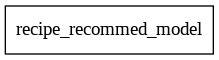

In [259]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested = True)

In [237]:
model.summary(expand_nested = True)

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
# zip tensorboard logs
!zip -r /content/log.zip /content/log/

In [ ]:
# zip mlflow logs
!zip -r /content/mlruns.zip /content/mlruns